In [ ]:
# ---------- Mount Google Drive ----------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the required libraries for audio processing and deep learning
!pip install --quiet librosa soundfile praat-parselmouth tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 81.3 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import warnings
import numpy as np
import librosa
import parselmouth
import tensorflow as tf
from google.colab import drive
from IPython.display import Audio, display

# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
# --- IMPORTANT ---
# These paths MUST match the output paths from your original training notebook

DRIVE_PATH = "/content/drive/MyDrive/"
MODEL_PATH = os.path.join(DRIVE_PATH, "emotion_recognition_model.h5")
SCALER_PATH = os.path.join(DRIVE_PATH, "feature_scaler.pkl")
ENCODER_PATH = os.path.join(DRIVE_PATH, "label_encoder.pkl")

In [ ]:
# Load the trained model
print("Loading trained model...")
model = tf.keras.models.load_model(MODEL_PATH)

# Load the scaler
print("Loading feature scaler...")
with open(SCALER_PATH, 'rb') as f:
    scaler = pickle.load(f)

# Load the label encoder
print("Loading label encoder...")
with open(ENCODER_PATH, 'rb') as f:
    le = pickle.load(f)

print("\n✅ All artifacts loaded successfully!")
print("Classes the model can predict:", le.classes_)

Loading trained model...


Loading feature scaler...
Loading label encoder...

✅ All artifacts loaded successfully!
Classes the model can predict: ['angry' 'disgust' 'happy' 'neutral' 'sad' 'scared']


In [ ]:
# This is the EXACT same feature extraction function from your training notebook.
# It is required to process new audio in the same way the training data was processed.

FRAME_LENGTH = 2048
HOP_LENGTH = 512
N_MFCC = 13


def extract_features(path, n_mfcc=N_MFCC, fmin=50.0, fmax=500.0):
    """Return a dict of features for a single audio file."""
    try:
        y, sr = librosa.load(path, sr=None, mono=True)
    except Exception as e:
        print('Load error', path, e)
        return None, None, None # Return None for y and sr as well

    # Basic
    duration = len(y) / sr
    mean_amp = float(np.mean(np.abs(y)))
    peak_amp = float(np.max(np.abs(y)))

    # RMS
    rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    rms_mean = float(np.mean(rms)) if len(rms) else 0.0
    rms_std = float(np.std(rms)) if len(rms) else 0.0

    # Intensity (dB)
    intensity_db_mean = float(np.mean(librosa.amplitude_to_db(np.maximum(rms, 1e-9))))

    # Tempo
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    try:
        tempo_val = float(librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0])
    except:
        tempo_val = 0.0

    # ZCR
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    zcr_mean = float(np.mean(zcr))
    zcr_std = float(np.std(zcr))

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=HOP_LENGTH)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Pitch: use parselmouth (Praat) for robust pitch estimation
    try:
        snd = parselmouth.Sound(path)
        pitch_obj = snd.to_pitch_ac(time_step=0.01)
        pitch_track = pitch_obj.selected_array['frequency']
        voiced = pitch_track[pitch_track > 0]
    except Exception as e:
        # fallback to librosa.yin
        try:
            pitch_track = librosa.yin(y, fmin=fmin, fmax=fmax, sr=sr, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            voiced = pitch_track[~np.isnan(pitch_track)]
            pitch_track = np.nan_to_num(pitch_track)
        except Exception:
            pitch_track = np.array([0.0])
            voiced = np.array([])

    if len(voiced) > 0:
        pitch_mean = float(np.mean(voiced))
        pitch_median = float(np.median(voiced))
        pitch_std = float(np.std(voiced))
        voiced_ratio = float(len(voiced) / max(1.0, len(pitch_track)))
    else:
        pitch_mean = pitch_median = pitch_std = voiced_ratio = 0.0

    pitch_variation = pitch_std

    # Prosody approximations
    def jitter(v):
        if len(v) < 2:
            return 0.0
        diffs = np.abs(np.diff(v))
        return float(np.mean(diffs) / (np.mean(v) + 1e-9))

    def shimmer(r):
        if len(r) < 2:
            return 0.0
        return float(np.std(r) / (np.mean(r) + 1e-9))

    jitter_val = jitter(voiced)
    shimmer_val = shimmer(rms)

    feats = {
        'path': path,
        'duration_sec': duration,
        'sample_rate': sr,
        'mean_amplitude': mean_amp,
        'peak_amplitude': peak_amp,
        'rms_mean': rms_mean,
        'rms_std': rms_std,
        'intensity_db_mean': intensity_db_mean,
        'tempo_bpm': tempo_val,
        'zcr_mean': zcr_mean,
        'zcr_std': zcr_std,
        'pitch_mean': pitch_mean,
        'pitch_median': pitch_median,
        'pitch_std': pitch_std,
        'pitch_variation': pitch_variation,
        'voiced_ratio': voiced_ratio,
        'jitter': jitter_val,
        'shimmer': shimmer_val,
    }

    for i in range(n_mfcc):
        feats[f'mfcc_mean_{i}'] = float(mfcc_mean[i])
        feats[f'mfcc_std_{i}'] = float(mfcc_std[i])

    return feats, y, sr # Return y and sr

In [ ]:
# This list MUST match the 'feature_cols' from your training notebook
# It defines which features are fed into the model.

mfcc_mean_cols = [f'mfcc_mean_{i}' for i in range(N_MFCC)]
basic_cols = [
    'duration_sec','sample_rate','mean_amplitude','peak_amplitude','rms_mean','rms_std',
    'intensity_db_mean','tempo_bpm','zcr_mean','zcr_std','pitch_mean','pitch_median','pitch_std',
    'pitch_variation','voiced_ratio','jitter','shimmer'
]
feature_cols = basic_cols + mfcc_mean_cols

print(f"The model expects {len(feature_cols)} features.")

The model expects 30 features.


In [ ]:
import matplotlib.pyplot as plt
import librosa.display

def predict_emotion(file_path):
    """
    Predicts the emotion from a single audio file path.
    """
    # 1. Extract features from the audio file
    print(f"Extracting features from {file_path}...")
    feats_dict, y, sr = extract_features(file_path) # Get y and sr here

    if feats_dict is None:
        return "Error: Could not process the audio file.", None, None, None # Add None for y and sr

    # Display extracted features
    print("\nExtracted Features:")
    for key, value in feats_dict.items():
        print(f"  {key}: {value}")


    # 2. Create the feature vector in the correct order
    feature_vector = []
    for col in feature_cols:
        # Use .get(col, 0) to provide a default value (0) if a feature is missing
        feature_vector.append(feats_dict.get(col, 0))

    # 3. Convert to numpy array, fill NaNs, and reshape
    X_new = np.array(feature_vector).astype('float32')
    X_new = np.nan_to_num(X_new)
    X_new = X_new.reshape(1, -1)  # Reshape to (1, num_features) for the model

    # 4. Scale the features using the loaded scaler
    X_new_scaled = scaler.transform(X_new)

    # 5. Make the prediction
    print("Model predicting...")
    pred_probs = model.predict(X_new_scaled)

    # 6. Get the predicted class index
    pred_index = np.argmax(pred_probs, axis=1)[0]

    # 7. Decode the index to the emotion label
    pred_emotion = le.inverse_transform([pred_index])[0]

    return pred_emotion, pred_probs[0], y, sr # Return y and sr

Please upload a .wav file...


Saving 03-01-03-02-01-02-13.wav to 03-01-03-02-01-02-13.wav

Playing uploaded audio:


Extracting features from /content/03-01-03-02-01-02-13.wav...

Extracted Features:
  path: /content/03-01-03-02-01-02-13.wav
  duration_sec: 3.6036041666666665
  sample_rate: 48000
  mean_amplitude: 0.009001999162137508
  peak_amplitude: 0.16180419921875
  rms_mean: 0.011359615251421928
  rms_std: 0.015414848923683167
  intensity_db_mean: -60.72745132446289
  tempo_bpm: 152.02702702702703
  zcr_mean: 0.061348638590976334
  zcr_std: 0.05378537365507979
  pitch_mean: 214.22496899575737
  pitch_median: 216.07696137997874
  pitch_std: 53.54377222789171
  pitch_variation: 53.54377222789171
  voiced_ratio: 0.4425770308123249
  jitter: 0.03666857808440756
  shimmer: 1.3569867610931396
  mfcc_mean_0: -569.4323120117188
  mfcc_std_0: 174.30137634277344
  mfcc_mean_1: 76.6044692993164
  mfcc_std_1: 69.64848327636719
  mfcc_mean_2: -7.522757053375244
  mfcc_std_2: 27.926788330078125
  mfcc_mean_3: 11.827301979064941
  mfcc_std_3: 20.07796859741211
  mfcc_mean_4: -4.339582443237305
  mfcc_std_4: 2

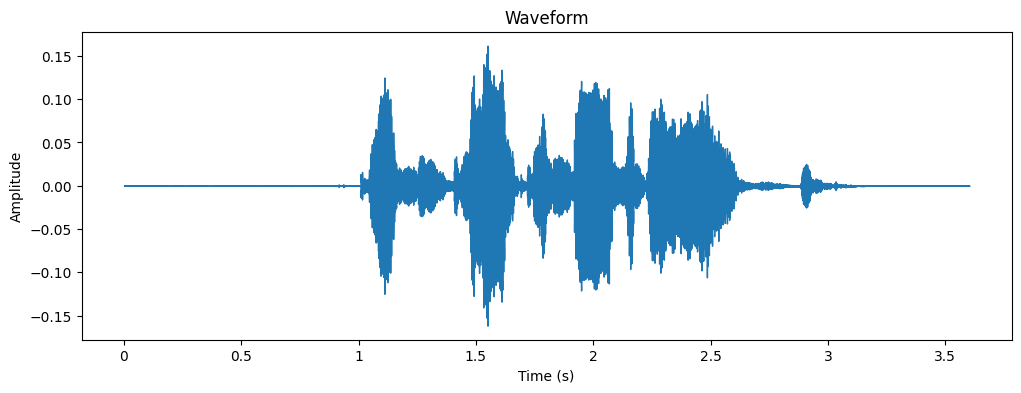

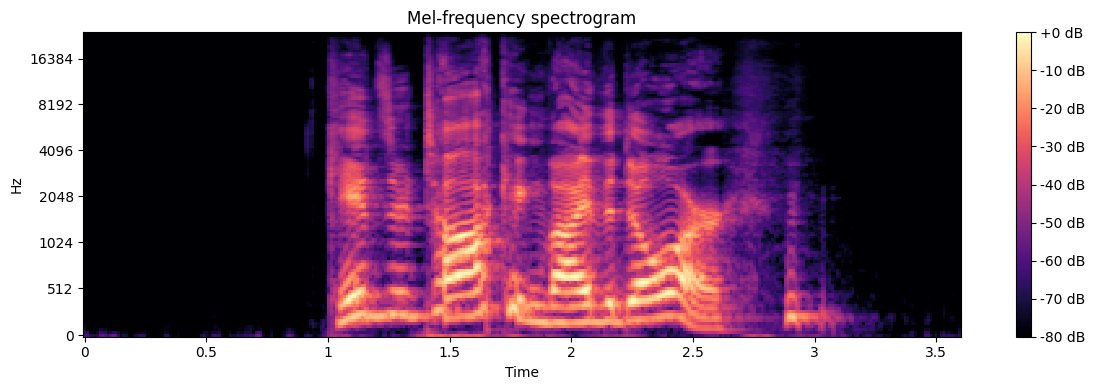

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import librosa.display

# 1. Upload an audio file
print("Please upload a .wav file...")
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Please run the cell again.")
else:
    # 2. Get the file path
    file_name = list(uploaded.keys())[0]
    file_path = f"/content/{file_name}"

    # 3. (Optional) Play the audio file
    print("\nPlaying uploaded audio:")
    display(Audio(file_path))

    # 4. Make the prediction
    emotion, probabilities, y, sr = predict_emotion(file_path) # Get y and sr here

    if y is not None and sr is not None: # Check if y and sr are not None
        # 5. Display the results
        print("\n--- 📊 Prediction Results ---")
        print(f"Predicted Emotion: **{emotion.upper()}**")
        print("\nConfidence Scores:")
        for i, label in enumerate(le.classes_):
            print(f"  {label.capitalize():<10}: {probabilities[i]*100:.2f}%")

        # 6. Display waveform plot
        plt.figure(figsize=(12, 4))
        librosa.display.waveshow(y, sr=sr)
        plt.title('Waveform')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()

        # 7. Display Mel Frequency Spectrogram
        plt.figure(figsize=(12, 4))
        M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=HOP_LENGTH, n_fft=FRAME_LENGTH)
        M_db = librosa.power_to_db(M, ref=np.max)
        librosa.display.specshow(M_db, sr=sr, x_axis='time', y_axis='mel', hop_length=HOP_LENGTH)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram')
        plt.tight_layout()
        plt.show()

    else:
        print(emotion) # Print the error message if y or sr is None